In [1]:
{-# LANGUAGE FlexibleContexts, MonadComprehensions, NoImplicitPrelude, RebindableSyntax #-}
import Language.Stochaskell
stochaskell

Stochaskell, version 0.1.0
Copyright (C) 2015-2020 David A Roberts
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under certain conditions; see the LICENSE for details.

Using installation directory at 
  /home/jovyan/stochaskell

In [2]:
pickStick :: RVec -> P Z
pickStick sticks = do
  stick <- pmf (pickStickPMF sticks)
  return stick

pickStickPMF :: RVec -> RVec
pickStickPMF sticks =
  let sticks' = vector [ 1 - (sticks!i) | i <- 1...infinity ]
      rems = scanlE (*) 1 sticks'
      probs = vector [ (sticks!i) * (rems!i) | i <- 1...infinity ]
  in probs

In [3]:
dp :: R -> P R -> P (P R)
dp alpha proc = do
  sticks <- joint vector [ beta 1 alpha | i <- 1...infinity ] :: P RVec
  atoms  <- joint vector [ proc         | i <- 1...infinity ]
  let randomDistribution = do
        stick <- pickStick sticks
        return (atoms!stick)
  return randomDistribution

In [4]:
dpmm :: Z -> P RVec
dpmm n = do
  let base = uniform 0 100
  paramDist <- dp 5 base
  params <- joint vector [ paramDist | j <- 1...n ]
  values <- joint vector [ normal (params!j) 1 | j <- 1...n ]
  return values

In [5]:
import Language.Church
values <- simChurchVec (dpmm 10000)

--- Generating Church code ---
(define (pmf probs)
  (letrec ((go (lambda (j u)
                 (if (<= u (probs j)) j
                     (go (+ j 1) (- u (probs j)))))))
    (go 1 (uniform 0 1))))
(define (bernoulli p) (if (flip p) 1 0))

(define (model) (letrec (
  
  
  (v_0_2 (mem (lambda (i_1_1) (letrec (
    (v_1_0 (- 1 (x_church_0_0 i_1_1))))
    v_1_0))))
  (v_0_3 (mem (lambda (i_1_0) (if (= 1 i_1_0) 1 (letrec (
    (i_1_11 (v_0_2 (- i_1_0 1)))
    (i_1_12 (v_0_3 (- i_1_0 1)))
    (v_1_0 (* i_1_12 i_1_11)))
    v_1_0)))))
  (v_0_4 (mem (lambda (i_1_1) (letrec (
    (v_1_0 (* (x_church_0_0 i_1_1) (v_0_3 i_1_1))))
    v_1_0))))
  
  (v_0_6 (mem (lambda (i_1_1) (letrec (
    )
    (x_church_0_1 (x_church_0_2 i_1_1))))))
  
  (x_church_0_0 (mem (lambda (i_1_1) (letrec (
    )
    (beta 1 5)))))
  (x_church_0_1 (mem (lambda (i_1_1) (letrec (
    )
    (uniform 0 100)))))
  (x_church_0_2 (mem (lambda (i_1_1) (letrec (
    )
    (pmf v_0_4)))))
  (x_church_0_3 (mem (lambda (i_1_1) 

In [6]:
:opt svg
import Language.Stochaskell.Plot

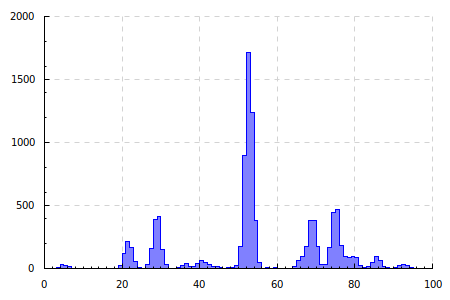

In [7]:
toRenderable . plot . return . histToPlot $ defaultPlotHist
  { _plot_hist_values = values, _plot_hist_bins = 100, _plot_hist_range = Just (0,100) }

In [8]:
import IHaskell.Display

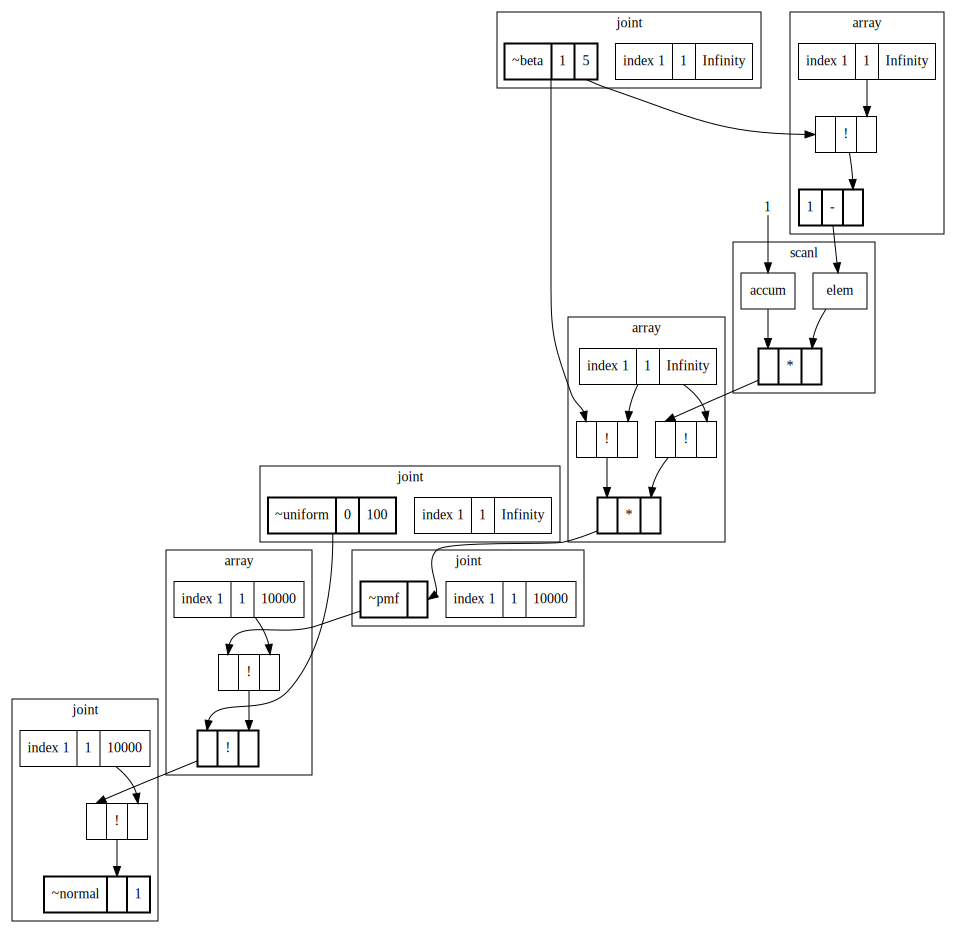

In [9]:
svg <$> vizIR (dpmm 10000)